# Project: Soccer Database - Brendon Dickerson

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Description**: The purpose of this project is to investigate a soccer SQL database and evaluate the dataset.  


### Question(s) for Analysis

>**Question 1**: What countries had the most amount of wins? Which country had the least amount of wins? What league had the most amount of wins? Which league had the least amount of wins?

>**Question 2**: Who is the top rated player in all of Europe?

>**Question 3**: How many players are  left footed? Right footed? What is the relationship between player rating and number of penalties?


<a id='wrangling'></a>
## Data Wrangling

In [338]:
# imprt packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [339]:
# import datasets
df_Country = pd.read_csv('Country.csv')
df_League = pd.read_csv('League.csv')
df_Player = pd.read_csv('Player_Attributes.csv')
df_Match = pd.read_csv('Match.csv')
df_Team = pd.read_csv('Team.csv')

In [340]:
df_Country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [341]:
df_League.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [342]:
df_Player.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [343]:
df_Match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [344]:
df_Team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [345]:
df_Country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [346]:
df_League.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
id            11 non-null int64
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(2), object(1)
memory usage: 344.0+ bytes


In [347]:
df_Player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [348]:
df_Match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [356]:
df_Team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [357]:
df_Country.columns[df_Country.isnull().any()]

Index([], dtype='object')

In [358]:
df_League.columns[df_League.isnull().any()]

Index([], dtype='object')

In [362]:
df_Player.columns[df_Player.isnull().any()]

Index(['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [363]:
df_Match.columns[df_Match.isnull().any()]

Index(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=104)

In [364]:
df_Team.columns[df_Team.isnull().any()]

Index(['team_fifa_api_id'], dtype='object')

In [365]:
df_Country.describe()

,id
count,11.000000
mean,12452.090909
std,8215.308472
min,1.000000
25%,6289.000000
50%,13274.000000
75%,18668.000000
max,24558.000000


In [366]:
df_League.describe()

,id,country_id
count,11.000000,11.000000
mean,12452.090909,12452.090909
std,8215.308472,8215.308472
min,1.000000,1.000000
25%,6289.000000,6289.000000
50%,13274.000000,13274.000000
75%,18668.000000,18668.000000
max,24558.000000,24558.000000


In [367]:
df_Player.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [368]:
df_Match.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
count,25979.000000,25979.000000,25979.000000,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000,24158.000000,...,17097.000000,22568.000000,22568.000000,22568.000000,14162.000000,14162.000000,14162.000000,14161.000000,14161.000000,14161.000000
mean,12990.000000,11738.630317,11738.630317,18.242773,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938,0.999586,...,4.622343,2.668107,3.899048,4.840281,2.498764,3.648189,4.353097,2.497894,3.660742,4.405663
std,7499.635658,7553.936759,7553.936759,10.407354,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110,0.022284,...,3.632164,1.928753,1.248221,4.318338,1.489299,0.867440,3.010189,1.507793,0.868272,3.189814
min,1.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000,0.000000,...,1.100000,1.030000,1.620000,1.080000,1.050000,1.450000,1.120000,1.040000,1.330000,1.120000
25%,6495.500000,4769.000000,4769.000000,9.000000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000,1.000000,...,2.500000,1.700000,3.300000,2.550000,1.670000,3.200000,2.500000,1.670000,3.250000,2.500000
50%,12990.000000,10257.000000,10257.000000,18.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000,1.000000,...,3.500000,2.150000,3.500000,3.500000,2.100000,3.300000,3.400000,2.100000,3.400000,3.400000
75%,19484.500000,17642.000000,17642.000000,27.000000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000,1.000000,...,5.250000,2.800000,4.000000,5.400000,2.650000,3.750000,5.000000,2.620000,3.750000,5.000000
max,25979.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000,2.000000,...,41.000000,36.000000,26.000000,67.000000,21.000000,11.000000,34.000000,17.000000,13.000000,34.000000


In [369]:
df_Team.describe()

,id,team_api_id,team_fifa_api_id
count,299.000000,299.000000,288.000000
mean,23735.301003,12340.521739,21534.305556
std,15167.914719,25940.411135,42456.439408
min,1.000000,1601.000000,1.000000
25%,9552.500000,8349.000000,178.750000
50%,22805.000000,8655.000000,673.500000
75%,36250.500000,9886.500000,1910.750000
max,51606.000000,274581.000000,112513.000000


In [370]:
df_Country.shape

(11, 2)

In [371]:
df_League.shape

(11, 3)

In [372]:
df_Player.shape

(183978, 42)

In [373]:
df_Match.shape

(25979, 115)

In [374]:
df_Team.shape

(299, 5)

In [375]:
# number of unique teams
df_Team['team_api_id'].nunique()

299

In [376]:
# number of unique seasons 
df_Match['season'].nunique()

8

In [377]:
# number of unique players
df_Player['id'].nunique()

183978

In [378]:
# Total number of Teams: 299
# Total number of Leagues: 11
# Total number of Seasons: 8
# Total number of Countries: 11
# Total number of Players: 183978

# Columns in each dataset: 2 (Country), 3 (League), 42 (Player), 115 (Match), 5 (Team)
# Columns with missing values: 0 (Country), 0 (League),  0 (Player),  104 (Match), 1 (Team)
# Samples in each dataset: 2 (Country), 3 (League), 183978 (Player), 115 (Match), 5 (Team)



### Data Cleaning

In [379]:
# Drop irrelevant columns in Match
df_Match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'], axis = 1, inplace = True)


In [380]:
df_Match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [381]:
# Drop irrelevant columns in Player
df_Player.drop(['potential','date'], axis = 1, inplace = True)


In [382]:
df_Player.head()

,id,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,67.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,67.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,62.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,61.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,61.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [383]:
# Drop irrelevant columns in League
df_League.drop(['id'], axis = 1, inplace = True)

In [384]:
df_League.head()

,country_id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A


In [385]:
df_Country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [386]:
df_Country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [387]:
df_League.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [388]:
df_Player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 40 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
overall_rating         183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agili

In [389]:
df_Match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 107 entries, id to BSA
dtypes: float64(96), int64(9), object(2)
memory usage: 21.2+ MB


In [390]:
df_Team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [391]:
# see if any values in Country are null
df_Country.isnull().sum().any()

False

In [392]:
# see if any values in League are null
df_League.isnull().sum().any()

False

In [393]:
# see if any values in Player are null
df_Player.isnull().sum().any()

True

In [394]:
# see if any values in Match are null
df_Match.isnull().sum().any()

True

In [395]:
# see if any values in Team are null
df_Team.isnull().sum().any()

True

In [396]:
# drop null values in Match
df_Match.dropna(axis=0, how='any', inplace=True)
df_Match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2626 entries, 997 to 23416
Columns: 107 entries, id to BSA
dtypes: float64(96), int64(9), object(2)
memory usage: 2.2+ MB


In [397]:
# drop null values in Team
df_Team.dropna(axis=0, how='any', inplace=True)
df_Team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 297
Data columns (total 5 columns):
id                  288 non-null int64
team_api_id         288 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      288 non-null object
team_short_name     288 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 13.5+ KB


In [398]:
# double check to see if null values were removed
df_Match.isnull().sum().any()

False

In [399]:
# double check to see if null values were removed
df_Team.isnull().sum().any()

False

In [400]:
# create a column with winner of each match
conditions = [(df_Match['home_team_goal'] > df_Match['away_team_goal']), (df_Match['home_team_goal'] < df_Match['away_team_goal'])]
choices = [df_Match['home_team_api_id'], df_Match['away_team_api_id']]
df_Match['winner'] = np.select(conditions, choices, default='draw')
df_Match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,winner
997,998,1,1,2012/2013,1,2012-07-28 00:00:00,1223977,9993,9994,2,...,2.40,3.4,2.9,2.45,3.3,2.7,2.40,3.25,2.7,9994
998,999,1,1,2012/2013,1,2012-07-28 00:00:00,1223980,9998,1773,5,...,1.80,3.6,4.5,1.75,3.7,4.2,1.80,3.50,4.0,9998
999,1000,1,1,2012/2013,1,2012-07-29 00:00:00,1223981,9985,10000,0,...,1.70,3.7,5.0,1.67,3.6,5.0,1.70,3.50,4.5,10000
1000,1001,1,1,2012/2013,1,2012-07-28 00:00:00,1223982,8203,9986,4,...,1.57,3.9,6.0,1.53,3.9,6.0,1.50,3.80,6.0,8203
1001,1002,1,1,2012/2013,1,2012-07-28 00:00:00,1223983,8342,8475,3,...,1.25,5.5,12.0,1.25,5.5,10.0,1.25,5.50,9.0,8342


In [401]:
# drop the draw values 
df_Match = df_Match[df_Match.winner != 'draw']

In [402]:
# change values in winner column to integers
df_Match['winner'] = df_Match['winner'].astype(int)

In [403]:
df_Match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 997 to 23416
Columns: 108 entries, id to winner
dtypes: float64(96), int64(10), object(2)
memory usage: 1.6+ MB


In [404]:
df_Country.to_csv('Country_v2.csv', index=False)
df_League.to_csv('League_v2.csv', index=False)
df_Player.to_csv('Player_Attributes_v2.csv', index=False)
df_Match.to_csv('Match_v2.csv', index=False)
df_Team.to_csv('Team_v2.csv', index=False)

In [405]:
# count matches won by each league
df_Match['league_id'].value_counts()

21518    284
10257    272
1729     270
4769     252
7809     227
13274    201
1        165
19694    136
17642    134
Name: league_id, dtype: int64

In [406]:
# count matches won by each Country
df_Match['country_id'].value_counts()

21518    284
10257    272
1729     270
4769     252
7809     227
13274    201
1        165
19694    136
17642    134
Name: country_id, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 - What countries had the most amount of wins? Which country had the least amount of wins? What league had the most amount of wins? Which league had the least amount of wins?

Text(0,0.5,'Matches')

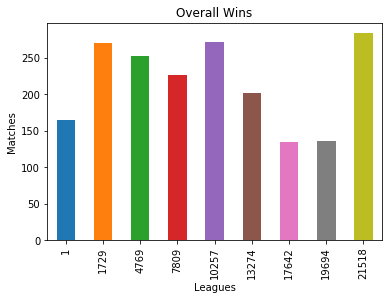

In [407]:
# plot matches by league
df_Match.groupby('league_id')['winner'].count().plot(kind='bar', title='Overall Wins');
plt.xlabel('Leagues')
plt.ylabel('Matches')


Text(0,0.5,'Matches')

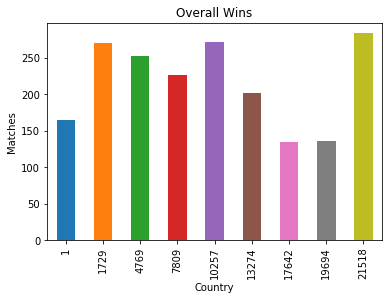

In [408]:
# plot matches by Country
df_Match.groupby('country_id')['winner'].count().plot(kind='bar', title='Overall Wins');
plt.xlabel('Country')
plt.ylabel('Matches')

### Research Question 2 - Who is the top rated player in all of Europe?

In [409]:
df_Player.head()

,id,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,67.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,67.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,62.0,right,medium,medium,49.0,44.0,71.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,61.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,61.0,right,medium,medium,48.0,43.0,70.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [410]:
# what is the overall rating for all players
df_Player['overall_rating'].mean()

68.600015288683096

In [411]:
# number of players above national rating
above = df_Player.query('overall_rating > overall_rating.mean()')
above['overall_rating'].count()

93475

In [412]:
# number of players below national rating 
below = df_Player.query('overall_rating < overall_rating.mean()')
below['overall_rating'].count()

89667

In [413]:
above.max()

id                     183978
player_fifa_api_id     232693
player_api_id          722766
overall_rating             94
preferred_foot          right
defensive_work_rate     tocky
crossing                   95
finishing                  97
heading_accuracy           98
short_passing              97
volleys                    93
dribbling                  97
curve                      94
free_kick_accuracy         97
long_passing               97
ball_control               97
acceleration               97
sprint_speed               97
agility                    96
reactions                  96
balance                    96
shot_power                 97
jumping                    96
stamina                    96
strength                   96
long_shots                 96
aggression                 97
interceptions              96
positioning                96
vision                     97
penalties                  96
marking                    96
standing_tackle            95
sliding_ta

### Research Question 3 - How many players are  left footed? Right footed? What is the relationship between player rating and number of penalties?

In [414]:
df = pd.DataFrame(df_Player)

In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 40 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
overall_rating         183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agili

In [416]:
df['preferred_foot'].value_counts(ascending=False)

right    138409
left      44733
Name: preferred_foot, dtype: int64

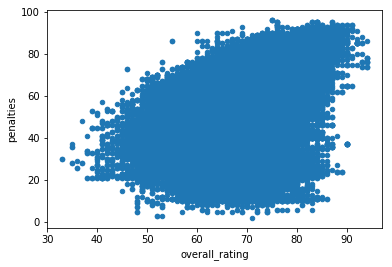

In [417]:
# pbserve relationship between overall rating and penalties
df_Player.plot(x='overall_rating', y='penalties', kind='scatter');

<a id='conclusions'></a>
## Conclusions

> Question 1: As you can see from the two plots, the plots are identical when changing the x-axis from league --> country. Portugal (id - 17642) has the least amount of wins and Spain (id - 21518) has the most wins. The Portugal Liga ZON Sagres (country_id - 17642) has the least amount of wins and Spain LIGA BBVA (country_id - 21518) has the most wins. This indicates leagues dont associate with other countries and are all contained within one country. 

> Question 2: Charly Musonda (player_api_id) is the top rated player in the dataset. Charly was the top rated player in Europe out of 11060 players.

> Question 3: There are a total of 138409 players that prefer their right foot compared to 44733 that prefer left foot. Majority of soccer(football) players prefer their right foot in Europe.


## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [418]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0